添加引用

In [4]:
import utils
import params
import cv2
import matplotlib.pyplot as plt
import pickle
import numpy as np


从Tesla数据集的视频中，得到训练图片。从数据集的车辆转向记录中读取转向数据，将转向数据和训练图片做一一对应，得到训练数据集。

In [72]:
from sklearn.model_selection import train_test_split

#加载epoch1到epoch9的所有视频的图片到img_list中，加载epoch1到epoch9的所有转向数据到steer_list，
for epoch_id in range(1,2):    
    vid_path = utils.join_dir(params.data_dir, 'epoch{:0>2}_front.mkv').format(epoch_id)
    steer_path = utils.join_dir(params.data_dir, 'epoch{:0>2}_steering.csv').format(epoch_id)
    steer_data = utils.fetch_csv_data(steer_path)
    
    steer_list = list(steer_data['wheel']) 
    
    frame_count = utils.frame_count(vid_path)
    cap = cv2.VideoCapture(vid_path)
    img_list = []
    
    for frame_id in range(frame_count):
        ret, img = cap.read()       
        img_resized = utils.img_pre_process(img)
        img_list.append(img_resized)
        
        if frame_id == frame_count - 1 and epoch_id == 9:
            print("img pre shape {}".format(img.shape))
            print("img after shape {}".format(img_resized.shape))
            plt.imshow(img)
            plt.show()
            plt.imshow(img_resized)
            plt.show()
    
    #随机打乱数据，取10%的训练数据做验证集
    img_list_train, img_list_val, steer_list_train, steer_list_val = train_test_split(img_list, steer_list, test_size=0.1, random_state=10)
    
    #把训练集和验证集存到本地
    train_add = 'epoch{:0>2}_preprocess_train.p'.format(epoch_id)
    val_add = 'epoch{:0>2}_preprocess_val.p'.format(epoch_id)
    pickle.dump((img_list_train, steer_list_train), open(train_add, 'wb'))
    pickle.dump((img_list_val, steer_list_val), open(val_add, 'wb'))
   # print (len(img_list_train))
  #  print(steer_list_val)



[-5.5, 0.0, 4.0, 4.0, 4.5, 0.5, 4.0, 1.0, 0.5, 4.5, -0.5, -4.5, 5.0, 0.0, 4.5, -4.0, 3.5, 1.0, 0.0, 4.5, -1.5, 3.0, 4.5, 4.5, -1.5, 0.5, 0.0, 0.5, -1.5, -5.5, -4.5, 5.0, -2.5, 4.5, 4.5, 4.0, 5.5, -3.5, 4.0, -4.5, -4.5, -4.5, 4.0, 1.0, 3.0, 0.5, 6.0, 1.0, 0.0, 0.5, -0.5, 0.5, 0.5, 0.5, 0.5, -5.0, 4.0, -2.5, 5.5, 1.0, 0.5, -5.0, 0.5, -4.0, 5.5, 6.0, -1.5, 1.0, 1.0, 0.5, 0.5, 3.0, 4.5, 0.5, 4.5, 5.0, 0.5, 4.0, 2.5, 5.5, 0.5, -2.0, 3.5, -1.5, 4.5, 4.0, -1.0, -5.0, -5.5, -3.5, -5.5, 1.0, 3.0, 0.5, 4.0, 3.0, -1.0, 1.0, -5.0, -1.5, -4.0, 5.5, 4.0, 0.0, -0.5, 0.5, 0.5, 3.5, 0.5, -0.5, 4.0, 0.5, 5.0, 1.0, 0.5, 0.5, 0.0, 3.0, -4.5, 5.0, 0.5, 4.5, -1.5, -6.0, 5.0, 0.0, -0.5, 5.0, 5.5, 0.0, 3.5, 0.5, -4.5, 2.5, 0.5, 0.5, 4.5, -4.5, -1.5, 0.5, 0.0, 0.0, 2.5, 0.5, 0.5, 0.5, 0.0, 0.5, -0.5, 4.0]


加载数据

In [52]:

def load_preprocess_training_batch(batch_id):
    filename = 'epoch{:0>2}_preprocess_train.p'.format(batch_id)
    img, steer = pickle.load(open(filename, mode='rb'))

    return img, steer
def load_preprocess_validating_batch(batch_id):
    filename = 'epoch{:0>2}_preprocess_val.p'.format(batch_id)
    img, steer = pickle.load(open(filename, mode='rb'))

    return img, steer

In [16]:
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
seed = 10

In [56]:
def simple_model_1(time_len=1):
      ch, row, col = 3, 64, 64  # camera format

      model = Sequential()
      model.add(Lambda(lambda x: x/127.5 - 1.,
            input_shape=(ch, row, col),
            output_shape=(ch, row, col)))
      model.add(Convolution2D(16, 8, 8, subsample=(4, 4), border_mode="same"))
      model.add(ELU())
      model.add(Convolution2D(32, 5, 5, subsample=(2, 2), border_mode="same"))
      model.add(ELU())
      model.add(Convolution2D(64, 5, 5, subsample=(2, 2), border_mode="same"))
      model.add(Flatten())
      model.add(Dropout(.2))
      model.add(ELU())
      model.add(Dense(512))
      model.add(Dropout(.5))
      model.add(ELU())
      model.add(Dense(1))

      model.compile(loss='mean_absolute_error', optimizer='rmsprop')

      

      return model

In [53]:
batch_size = 64
epoches = 3

In [62]:
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
def train_model(x_train, y_train, x_val, y_val, model_func):
    model = model_func()
    model.fit(x_train, y_train, nb_epoch = epoches, batch_size = batch_size)
    pre = model.predict(x_val, batch_size=batch_size, verbose=0)
    score = r2_score(y_val, pre)
    print("score: %.2f " % (score))
    
    print (y_val)
    plt.plot(len(pre), y_val, 'o-', color = 'b', label = 'true steer')
  #  plt.plot(len(pre), pre, 'o-', color = 'g', label = 'predited steer')

训练单个视频

/Users/sengled/anaconda3/envs/dlnd-tf-lab/lib/python3.5/site-packages/ipykernel_launcher.py:8: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(16, (8, 8), padding="same", strides=(4, 4))`
  
/Users/sengled/anaconda3/envs/dlnd-tf-lab/lib/python3.5/site-packages/ipykernel_launcher.py:10: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (5, 5), padding="same", strides=(2, 2))`
  # Remove the CWD from sys.path while we load stuff.
/Users/sengled/anaconda3/envs/dlnd-tf-lab/lib/python3.5/site-packages/ipykernel_launcher.py:12: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (5, 5), padding="same", strides=(2, 2))`
  if sys.path[0] == '':
/Users/sengled/anaconda3/envs/dlnd-tf-lab/lib/python3.5/site-packages/keras/models.py:939: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Epoch 1/3
1350/1350 [==============================] - 2s 1ms/step - loss: 2.4805
Epoch 2/3
1350/1350 [==============================] - 1s 873us/step - loss: 1.6816
Epoch 3/3
1350/1350 [==============================] - 1s 857us/step - loss: 1.3554
score: 0.61 
[-5.5, 0.0, 4.0, 4.0, 4.5, 0.5, 4.0, 1.0, 0.5, 4.5, -0.5, -4.5, 5.0, 0.0, 4.5, -4.0, 3.5, 1.0, 0.0, 4.5, -1.5, 3.0, 4.5, 4.5, -1.5, 0.5, 0.0, 0.5, -1.5, -5.5, -4.5, 5.0, -2.5, 4.5, 4.5, 4.0, 5.5, -3.5, 4.0, -4.5, -4.5, -4.5, 4.0, 1.0, 3.0, 0.5, 6.0, 1.0, 0.0, 0.5, -0.5, 0.5, 0.5, 0.5, 0.5, -5.0, 4.0, -2.5, 5.5, 1.0, 0.5, -5.0, 0.5, -4.0, 5.5, 6.0, -1.5, 1.0, 1.0, 0.5, 0.5, 3.0, 4.5, 0.5, 4.5, 5.0, 0.5, 4.0, 2.5, 5.5, 0.5, -2.0, 3.5, -1.5, 4.5, 4.0, -1.0, -5.0, -5.5, -3.5, -5.5, 1.0, 3.0, 0.5, 4.0, 3.0, -1.0, 1.0, -5.0, -1.5, -4.0, 5.5, 4.0, 0.0, -0.5, 0.5, 0.5, 3.5, 0.5, -0.5, 4.0, 0.5, 5.0, 1.0, 0.5, 0.5, 0.0, 3.0, -4.5, 5.0, 0.5, 4.5, -1.5, -6.0, 5.0, 0.0, -0.5, 5.0, 5.5, 0.0, 3.5, 0.5, -4.5, 2.5, 0.5, 0.5, 4.5, -4.5, -1.5, 0

ValueError: x and y must have same first dimension, but have shapes (1,) and (150,)

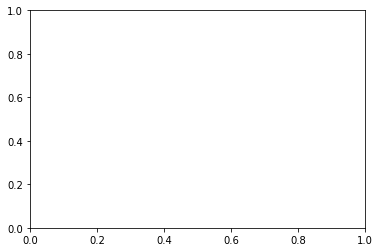

In [73]:
img_train, steer_train = load_preprocess_training_batch(1)
img_val, steer_val = load_preprocess_validating_batch(1)
img_train = np.array(img_train).transpose(0, 3, 2, 1)
img_val = np.array(img_val).transpose(0, 3, 2, 1)

train_model(np.array(img_train), steer_train, np.array(img_val), steer_val, simple_model_1)

对输入图像进行标准化处理

In [ ]:
def normalize(x):
    """
    Normalize a list of sample image data in the range of 0 to 1
    : x: List of image data.  The image shape is (32, 32, 3)
    : return: Numpy array of normalize data
    """
    # TODO: Implement Function
    a = 0
    b = 1
    min = 0
    max = 255
    x[(x < 0)]= 0;
    x[(x > 255)]= 255;
    
    return a + ( ( (x - min)*(b - a) )/( max - min ) )

创建简单网络

In [ ]:
import tensorflow as tf
from sklearn.metrics import mean_squared_error, r2_score
def conv2d_maxpool(x_tensor, conv_num_outputs, conv_ksize, conv_strides, pool_ksize, pool_strides):    
    inputChanel = x_tensor.get_shape().as_list()[3]
    W = tf.Variable(tf.truncated_normal([conv_ksize[0], conv_ksize[1], inputChanel, conv_num_outputs], stddev = 0.05))
    B = tf.Variable(tf.zeros([conv_num_outputs]))
    conv = tf.nn.conv2d(x_tensor, W, strides =[1,conv_strides[0],conv_strides[1],1], padding='SAME')
    conv = tf.nn.bias_add(conv, B)
    conv = tf.nn.relu(conv)
    conv = tf.nn.max_pool(
        conv,
        ksize=[1, pool_ksize[0], pool_ksize[1], 1],
        strides=[1, pool_strides[0], pool_strides[1], 1],
        padding='SAME')
    return conv 
def flatten(x_tensor):
    return tf.reshape(x_tensor, [-1, x_tensor.get_shape().as_list()[1] * x_tensor.get_shape().as_list()[2] * x_tensor.get_shape().as_list()[3]])

def fully_conn(x_tensor, num_outputs):
    weight = tf.Variable(tf.random_normal([x_tensor.get_shape().as_list()[1], num_outputs]))
    bias = tf.Variable(tf.random_normal([num_outputs]))
    fc = tf.add(tf.matmul(x_tensor, weight), bias)
    return tf.nn.relu(fc)

def output(x_tensor, num_outputs):
    weight = tf.Variable(tf.random_normal([x_tensor.get_shape().as_list()[1], num_outputs]))
    bias = tf.Variable(tf.random_normal([num_outputs]))
    return tf.add(tf.matmul(x_tensor, weight), bias)

def conv_net(x, keep_prob):
    
    conv_1 = conv2d_maxpool(x, 128, (3,3), (1,1), (2,2), (2,2))
    conv_2 = conv2d_maxpool(conv_1, 256, (1,1), (1,1), (2,2), (2,2))
    conv_3 = conv2d_maxpool(conv_2, 384, (9,9), (1,1), (2,2), (2,2))
    
    conv_4 = conv2d_maxpool(conv_3, 512, (1,1), (1,1), (2,2), (2,2))

    # TODO: Apply a Flatten Layer
    # Function Definition from Above:
    #   flatten(x_tensor)
    fl = flatten(conv_4)

    # TODO: Apply 1, 2, or 3 Fully Connected Layers
    #    Play around with different number of outputs
    # Function Definition from Above:
    #   fully_conn(x_tensor, num_outputs)
    fc_1 = fully_conn(fl, 1024)
   # fc_2 = fully_conn(fc_1, 512)
   # fc_3 = fully_conn(fc_2, 256)
    
    dr = tf.nn.dropout(fc_1, keep_prob)
    # TODO: Apply an Output Layer
    #    Set this to the number of classes
    # Function Definition from Above:
    #   output(x_tensor, num_outputs)
    out = output(dr, 10)
    
    # TODO: return output
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""

##############################
## Build the Neural Network ##
##############################

# Remove previous weights, bias, inputs, etc..
tf.reset_default_graph()

# Inputs
x = tf.placeholder(tf.float32, shape=[None, 32， 32， 3], name = 'x')
y = tf.placeholder(tf.float32, name = 'y')
keep_prob = tf.placeholder(tf.float32, name = 'keep_prob')

# Model
logits = conv_net(x, keep_prob)

# Name logits Tensor, so that is can be loaded from disk after training
logits = tf.identity(logits, name='logits')

# Loss and Optimizer
los = tf.reduce_mean(tf.pow(logits - y, 2))
learning_rate = 0.01
optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(los)

# Accuracy

score = r2_score(y, logits)



训练简单网络

In [ ]:
def train_simple_neural_network(session, optimizer, keep_probability, feature_batch, label_batch):   
    session.run(optimizer, feed_dict={
                x: feature_batch,
                y: label_batch,
                keep_prob: keep_probability})
def print_stats(session, feature_batch, label_batch, cost, accuracy,keep_probability):
    loss = session.run(cost, feed_dict={
                x: feature_batch,
                y: label_batch,
                keep_prob: 1
                })
    valid_score = session.run(score, feed_dict={
                x: valid_features,
                y: valid_labels,
                keep_prob: 1
                })

    print('Loss: {:>10.4f} score: {:.6f}'.format(
                loss,
                valid_score))

In [ ]:
epochs = 50
batch_size = 128
keep_probability = 0.6

在单个视频中训练

In [ ]:
print('Checking the Training on a Single Batch...')
with tf.Session() as sess:
    # Initializing the variables
    sess.run(tf.global_variables_initializer())
    
    # Training cycle
    for epoch in range(epochs):
        batch_i = 1
        for batch_img, batch_steer in helper.load_preprocess_training_batch(batch_i, batch_size):
            train_simple_neural_network(sess, optimizer, keep_probability, batch_img, batch_steer)
        print('Epoch {:>2}, video Batch {}:  '.format(epoch + 1, batch_i), end='')
        print_stats(sess, batch_img, batch_steer, cost, accuracy, keep_probability)

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import tensorflow as tf
import pickle
import helper
import random

# Set batch size if not already set
try:
    if batch_size:
        pass
except NameError:
    batch_size = 64

save_model_path = utils.join_dir(params.model_dir, 'model_{}.json'.format(epoch))
n_samples = 4
top_n_predictions = 3

def test_model():
    """
    Test the saved model against the test dataset
    """

    test_features, test_labels = pickle.load(open('preprocess_test.p', mode='rb'))
    loaded_graph = tf.Graph()

    with tf.Session(graph=loaded_graph) as sess:
        # Load model
        loader = tf.train.import_meta_graph(save_model_path + '.meta')
        loader.restore(sess, save_model_path)

        # Get Tensors from loaded model
        loaded_x = loaded_graph.get_tensor_by_name('x:0')
        loaded_y = loaded_graph.get_tensor_by_name('y:0')
        loaded_keep_prob = loaded_graph.get_tensor_by_name('keep_prob:0')
        loaded_logits = loaded_graph.get_tensor_by_name('logits:0')
        loaded_acc = loaded_graph.get_tensor_by_name('accuracy:0')
        
        # Get accuracy in batches for memory limitations
        test_batch_acc_total = 0
        test_batch_count = 0
        
        for test_feature_batch, test_label_batch in helper.batch_features_labels(test_features, test_labels, batch_size):
            test_batch_acc_total += sess.run(
                loaded_acc,
                feed_dict={loaded_x: test_feature_batch, loaded_y: test_label_batch, loaded_keep_prob: 1.0})
            test_batch_count += 1

        print('Testing Accuracy: {}\n'.format(test_batch_acc_total/test_batch_count))

        # Print Random Samples
        random_test_features, random_test_labels = tuple(zip(*random.sample(list(zip(test_features, test_labels)), n_samples)))
        random_test_predictions = sess.run(
            tf.nn.top_k(tf.nn.softmax(loaded_logits), top_n_predictions),
            feed_dict={loaded_x: random_test_features, loaded_y: random_test_labels, loaded_keep_prob: 1.0})
        helper.display_image_predictions(random_test_features, random_test_labels, random_test_predictions)


test_model()